In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-smartphone-decimeter-challenge/sample_submission.csv
/kaggle/input/google-smartphone-decimeter-challenge/baseline_locations_train.csv
/kaggle/input/google-smartphone-decimeter-challenge/baseline_locations_test.csv
/kaggle/input/google-smartphone-decimeter-challenge/metadata/constellation_type_mapping.csv
/kaggle/input/google-smartphone-decimeter-challenge/metadata/accumulated_delta_range_state_bit_map.json
/kaggle/input/google-smartphone-decimeter-challenge/metadata/raw_state_bit_map.json
/kaggle/input/google-smartphone-decimeter-challenge/test/2021-04-29-US-MTV-2/SamsungS20Ultra/SamsungS20Ultra_GnssLog.txt
/kaggle/input/google-smartphone-decimeter-challenge/test/2021-04-29-US-MTV-2/SamsungS20Ultra/SamsungS20Ultra_derived.csv
/kaggle/input/google-smartphone-decimeter-challenge/test/2021-04-29-US-MTV-2/SamsungS20Ultra/supplemental/SamsungS20Ultra_GnssLog.21o
/kaggle/input/google-smartphone-decimeter-challenge/test/2021-04-29-US-MTV-2/Pixel5/Pixel5_derived.csv
/kaggl

In [2]:
! pip3 install simdkalman

import keras 
import os
import haversine 
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
import pathlib
import plotly
from datetime import datetime 
import plotly.express as px 
from sklearn.linear_model import Ridge, RidgeCV
import matplotlib.pyplot as plt 
from sklearn import linear_model  
from sklearn.ensemble import IsolationForest 
import warnings
from sklearn.model_selection import KFold
from numba import jit
import joblib
import numpy as np
import pandas as pd
# import modin.pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb 
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import mode 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.layers import LeakyReLU, Input, concatenate, Dense, LSTM, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation, Reshape, Embedding, Add, Subtract, LeakyReLU, Flatten, AdditiveAttention
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.metrics import AUC 
from tensorflow.keras.activations import swish, relu
from tensorflow.keras.backend import square 
from keras.engine.topology import Layer 
from keras import backend as K
import warnings 
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV
import random 
from sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler
import simdkalman
from pathlib import Path
from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
import gc 
from sklearn.metrics import r2_score
seeds = [2022]
warnings.filterwarnings("ignore")

In [3]:
from scipy.interpolate import interp1d


def mean_with_other_phones(df):
    """
    https://www.kaggle.com/bpetrb/adaptive-gauss-phone-mean
    """
    collections_list = df[['collectionName']].drop_duplicates().to_numpy()

    for collection in collections_list:
        phone_list = df[df['collectionName'].to_list() == collection][['phoneName']].drop_duplicates().to_numpy()

        phone_data = {}
        corrections = {}
        for phone in phone_list:
            cond = np.logical_and(df['collectionName'] == collection[0], df['phoneName'] == phone[0]).to_list()
            phone_data[phone[0]] = df[cond][['millisSinceGpsEpoch', 'latDeg', 'lngDeg']].to_numpy()

        for current in phone_data:
            correction = np.ones(phone_data[current].shape, dtype=np.float)
            correction[:, 1:] = phone_data[current][:, 1:]

            # Telephones data don't complitely match by time, so - interpolate.
            for other in phone_data:
                if other == current:
                    continue

                loc = interp1d(phone_data[other][:, 0],
                               phone_data[other][:, 1:],
                               axis=0,
                               kind='linear',
                               copy=False,
                               bounds_error=None,
                               fill_value='extrapolate',
                               assume_sorted=True)

                start_idx = 0
                stop_idx = 0
                for idx, val in enumerate(phone_data[current][:, 0]):
                    if val < phone_data[other][0, 0]:
                        start_idx = idx
                    if val < phone_data[other][-1, 0]:
                        stop_idx = idx

                if stop_idx - start_idx > 0:
                    correction[start_idx:stop_idx, 0] += 1
                    correction[start_idx:stop_idx, 1:] += loc(phone_data[current][start_idx:stop_idx, 0])

            correction[:, 1] /= correction[:, 0]
            correction[:, 2] /= correction[:, 0]

            corrections[current] = correction.copy()

        for phone in phone_list:
            cond = np.logical_and(df['collectionName'] == collection[0], df['phoneName'] == phone[0]).to_list()

            df.loc[cond, ['latDeg', 'lngDeg']] = corrections[phone[0]][:, 1:]

    return df

In [4]:
train_pd = pd.read_csv("../input/feature-eng/trainset_pandas.csv")
val_pd = pd.read_csv("../input/feature-eng/valset_pandas.csv")
test_data = pd.read_csv("../input/feature-eng/testset_pandas.csv")

train_data = pd.read_csv("../input/feature-eng/total_trainset_pandas.csv")

In [5]:
cat_cols = [
    'correctedPrm_avg_bucketized',
    'rawPrUncM_avg_bucketized',
    'satClkDriftMps_avg_bucketized',
    'correctedPrm_std_bucketized',
    'rawPrUncM_std_bucketized',
    'satClkDriftMps_std_bucketized',
    "phoneCat"
]

numerical_cols = [
     'latDeg',
     'lngDeg',
     'heightAboveWgs84EllipsoidM',
     'ratio_of_year',
     'mean_latDeg+-1',
     'mean_lngDeg+-1',
     'latDeg_mean_delta_1',
     'lngDeg_mean_delta_1',
     'mean_latDeg+-2',
     'mean_lngDeg+-2',
     'latDeg_mean_delta_2',
     'lngDeg_mean_delta_2',
     'mean_latDeg+-3',
     'mean_lngDeg+-3',
     'latDeg_mean_delta_3',
     'lngDeg_mean_delta_3',
     'mean_latDeg+-4',
     'mean_lngDeg+-4',
     'latDeg_mean_delta_4',
     'lngDeg_mean_delta_4',
     'mean_latDeg+-5',
     'mean_lngDeg+-5',
     'latDeg_mean_delta_5',
     'lngDeg_mean_delta_5',
     'latDeg_pre_increment',
     'lngDeg_pre_increment',
     'latDeg_post_increment',
     'lngDeg_post_increment',
     'dist_pre',
     'dist_post',
     'latDeg_pre_post_mean_abs_delta',
     'lngDeg_pre_post_mean_abs_delta',
     'pre_post_mean_abs_dist',
     'max_latDeg_with_same_millisSinceGpsEpoch',
     'max_lngDeg_with_same_millisSinceGpsEpoch',
     'max_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'min_latDeg_with_same_millisSinceGpsEpoch',
     'min_lngDeg_with_same_millisSinceGpsEpoch',
     'min_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'mean_latDeg_with_same_millisSinceGpsEpoch',
     'mean_lngDeg_with_same_millisSinceGpsEpoch',
     'mean_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'sum_latDeg_with_same_millisSinceGpsEpoch',
     'sum_lngDeg_with_same_millisSinceGpsEpoch',
     'sum_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'count_latDeg_with_same_millisSinceGpsEpoch',
     'dist_between_baseline_and_phone_mean',
     'Cn0DbHz_avg',
     'BiasUncertaintyNanos_avg',
     'Cn0DbHz_std',
     'BiasUncertaintyNanos_std',
     'UncalAccelXMps2_avg',
     'UncalAccelYMps2_avg',
     'UncalAccelZMps2_avg',
     'UncalAccelXMps2_std',
     'UncalAccelYMps2_std',
     'UncalAccelZMps2_std',
     'UncalGyroXRadPerSec_avg',
     'UncalGyroYRadPerSec_avg',
     'UncalGyroZRadPerSec_avg',
     'UncalGyroXRadPerSec_std',
     'UncalGyroYRadPerSec_std',
     'UncalGyroZRadPerSec_std',
     'UncalMagXMicroT_avg',
     'UncalMagYMicroT_avg',
     'UncalMagZMicroT_avg',
     'UncalMagXMicroT_std',
     'UncalMagYMicroT_std',
     'UncalMagZMicroT_std',
     'latDeg_kf',
     'lngDeg_kf',
     'dist_between_base_and_kf',
     'base_kf_lat_delta',
     'base_kf_lng_delta',
     'abs_base_kf_lng_delta',
     'abs_base_kf_lat_delta'
]

feature_cols = [
     'latDeg',
     'lngDeg',
     'heightAboveWgs84EllipsoidM',
     'phoneCat',
     'ratio_of_year',
     'mean_latDeg+-1',
     'mean_lngDeg+-1',
     'latDeg_mean_delta_1',
     'lngDeg_mean_delta_1',
     'mean_latDeg+-2',
     'mean_lngDeg+-2',
     'latDeg_mean_delta_2',
     'lngDeg_mean_delta_2',
     'mean_latDeg+-3',
     'mean_lngDeg+-3',
     'latDeg_mean_delta_3',
     'lngDeg_mean_delta_3',
     'mean_latDeg+-4',
     'mean_lngDeg+-4',
     'latDeg_mean_delta_4',
     'lngDeg_mean_delta_4',
     'mean_latDeg+-5',
     'mean_lngDeg+-5',
     'latDeg_mean_delta_5',
     'lngDeg_mean_delta_5',
     'latDeg_pre_increment',
     'lngDeg_pre_increment',
     'latDeg_post_increment',
     'lngDeg_post_increment',
     'dist_pre',
     'dist_post',
     'latDeg_pre_post_mean_abs_delta',
     'lngDeg_pre_post_mean_abs_delta',
     'pre_post_mean_abs_dist',
     'max_latDeg_with_same_millisSinceGpsEpoch',
     'max_lngDeg_with_same_millisSinceGpsEpoch',
     'max_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'min_latDeg_with_same_millisSinceGpsEpoch',
     'min_lngDeg_with_same_millisSinceGpsEpoch',
     'min_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'mean_latDeg_with_same_millisSinceGpsEpoch',
     'mean_lngDeg_with_same_millisSinceGpsEpoch',
     'mean_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'sum_latDeg_with_same_millisSinceGpsEpoch',
     'sum_lngDeg_with_same_millisSinceGpsEpoch',
     'sum_heightAboveWgs84EllipsoidM_with_same_millisSinceGpsEpoch',
     'count_latDeg_with_same_millisSinceGpsEpoch',
     'dist_between_baseline_and_phone_mean',
     'correctedPrm_avg_bucketized',
     'rawPrUncM_avg_bucketized',
     'satClkDriftMps_avg_bucketized',
     'correctedPrm_std_bucketized',
     'rawPrUncM_std_bucketized',
     'satClkDriftMps_std_bucketized',
     'Cn0DbHz_avg',
     'BiasUncertaintyNanos_avg',
     'Cn0DbHz_std',
     'BiasUncertaintyNanos_std',
     'UncalAccelXMps2_avg',
     'UncalAccelYMps2_avg',
     'UncalAccelZMps2_avg',
     'UncalAccelXMps2_std',
     'UncalAccelYMps2_std',
     'UncalAccelZMps2_std',
     'UncalGyroXRadPerSec_avg',
     'UncalGyroYRadPerSec_avg',
     'UncalGyroZRadPerSec_avg',
     'UncalGyroXRadPerSec_std',
     'UncalGyroYRadPerSec_std',
     'UncalGyroZRadPerSec_std',
     'UncalMagXMicroT_avg',
     'UncalMagYMicroT_avg',
     'UncalMagZMicroT_avg',
     'UncalMagXMicroT_std',
     'UncalMagYMicroT_std',
     'UncalMagZMicroT_std',
     'latDeg_kf',
     'lngDeg_kf',
     'dist_between_base_and_kf',
     'base_kf_lat_delta',
     'base_kf_lng_delta',
     'abs_base_kf_lng_delta',
     'abs_base_kf_lat_delta'
]
label_cols = ["dist_between_baseline_and_truth"]

xtr = train_pd[feature_cols]
ytr = train_pd[label_cols]
xval = val_pd[feature_cols]
yval = val_pd[label_cols]

In [6]:
xtr_num = xtr[numerical_cols]
xval_num = xval[numerical_cols]

xtr_cat_one_hot_1 = pd.get_dummies(xtr[[cat_cols[0]]].astype('str'))
xtr_cat_one_hot_2 = pd.get_dummies(xtr[[cat_cols[1]]].astype('str'))
xtr_cat_one_hot_3 = pd.get_dummies(xtr[[cat_cols[2]]].astype('str'))
xtr_cat_one_hot_4 = pd.get_dummies(xtr[[cat_cols[3]]].astype('str'))
xtr_cat_one_hot_5 = pd.get_dummies(xtr[[cat_cols[4]]].astype('str'))
xtr_cat_one_hot_6 = pd.get_dummies(xtr[[cat_cols[5]]].astype('str'))
xtr_cat_one_hot_7 = pd.get_dummies(xtr[[cat_cols[6]]].astype('str'))

xval_cat_one_hot_1 = pd.get_dummies(xval[[cat_cols[0]]].astype('str'))
xval_cat_one_hot_2 = pd.get_dummies(xval[[cat_cols[1]]].astype('str'))
xval_cat_one_hot_3 = pd.get_dummies(xval[[cat_cols[2]]].astype('str'))
xval_cat_one_hot_4 = pd.get_dummies(xval[[cat_cols[3]]].astype('str'))
xval_cat_one_hot_5 = pd.get_dummies(xval[[cat_cols[4]]].astype('str'))
xval_cat_one_hot_6 = pd.get_dummies(xval[[cat_cols[5]]].astype('str'))
xval_cat_one_hot_7 = pd.get_dummies(xval[[cat_cols[6]]].astype('str'))

In [7]:
xtr_num.head()

,latDeg,lngDeg,heightAboveWgs84EllipsoidM,ratio_of_year,mean_latDeg+-1,mean_lngDeg+-1,latDeg_mean_delta_1,lngDeg_mean_delta_1,mean_latDeg+-2,mean_lngDeg+-2,...,UncalMagXMicroT_std,UncalMagYMicroT_std,UncalMagZMicroT_std,latDeg_kf,lngDeg_kf,dist_between_base_and_kf,base_kf_lat_delta,base_kf_lng_delta,abs_base_kf_lng_delta,abs_base_kf_lat_delta
0,37.423575,-122.094091,-34.06,0.367123,37.423577,-122.094096,1.200000e-06,4.800000e-06,37.423577,-122.094096,...,0.274189,0.520436,1.391013,37.423549,-122.094006,8.038813,2.585109e-05,-0.000085,0.000085,2.585109e-05
1,37.423578,-122.094101,-33.29,0.367123,37.423575,-122.094101,2.266667e-06,9.999999e-08,37.423575,-122.094101,...,0.289527,0.523330,1.775280,37.423564,-122.094063,3.671667,1.323695e-05,-0.000038,0.000038,1.323695e-05
2,37.423573,-122.094111,-30.99,0.367123,37.423578,-122.094111,4.566667e-06,9.999999e-08,37.423578,-122.094111,...,0.302098,0.517462,1.471444,37.423573,-122.094098,1.181473,3.600620e-07,-0.000013,0.000013,3.600620e-07
3,37.423583,-122.094121,-32.83,0.367123,37.423578,-122.094115,4.200000e-06,5.833333e-06,37.423578,-122.094115,...,0.292028,0.529593,1.146053,37.423578,-122.094116,0.691993,4.755944e-06,-0.000005,0.000005,4.755944e-06
4,37.423579,-122.094114,-34.49,0.367123,37.423580,-122.094120,7.000000e-07,6.600000e-06,37.423580,-122.094120,...,0.275674,0.573454,1.291866,37.423579,-122.094123,0.807182,3.825198e-07,0.000009,0.000009,3.825198e-07


In [8]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()

In [9]:
xtr_num = ss.fit_transform(xtr_num)
xval_num = ss.transform(xval_num)

# xtr_num = xtr_num.values
# xval_num = xval_num.values

In [10]:
# def create_nn_model(
#     num_columns, cat, output_dim, hidden_units, dropout_rates, learning_rate, activation, nns=nns
# ):

#     inp = Input(shape=(num_columns,))
    
#     x = BatchNormalization()(inp)
#     x = Dropout(dropout_rates[0])(x)
#     x = Concatenate(axis=-1)([x, tf.keras.backend.log(tf.abs(x)), 1 / (x + 1e-25)])
#     x = nns(x, hidden_units, activation, dropout_rates)
# #     x = tf.reshape(x, [1, -1])
# #     x = AdditiveAttention(causal=True)([x_, x])
    
#     out = Dense(output_dim)(x)

#     model = Model(inputs=inp, outputs=out)
#     model.compile(
# #         optimizer=Adam(learning_rate=learning_rate),
#         optimizer=AdamW(learning_rate=learning_rate, weight_decay=1e-5),
# #         optimizer='rmsprop',
#         loss=[my_loss],
#         metrics=['mae', smape_error, r2]
#     )

#     return model 

# def smape_error(y_true, y_pred):
#     return K.mean(K.clip(K.abs(y_pred - y_true),  0.0, 1.0), axis=-1)

# def r2(y_true, y_pred):
#     a = K.square(y_pred - y_true)
#     b = K.sum(a)
#     c = K.mean(y_true)
#     d = K.square(y_true - c)
#     e = K.sum(d)
#     f = 1 - b / e
#     return f 

# def weighted_smooth_l1_loss(output, label, weight_of_underestimate):
#     res = output - label
#     return (res[res > 0].sum() - (res[res < 0]).sum() * weight_of_underestimate) / output.shape[0]

# def weighted_smooth_l1_loss(y_true, y_pred):
#     loss_less = 1.0 
#     loss_more = 2.0 
#     res = y_pred - y_true 
#     return tf.reduce_sum(tf.where(tf.greater(y_pred, y_true), res * loss_less, - res * loss_more))

# def my_loss(y_true, y_pred):
#     maes = tf.compat.v1.losses.absolute_difference(y_true, y_pred)
#     maes_loss = tf.reduce_sum(maes)
#     return maes_loss 

# def weighted_smooth_l1_loss(output, label, weight_of_underestimate):
#     res = output - label
#     return (res[res > 0].sum() - (res[res < 0]).sum() * weight_of_underestimate) / output.shape[0]

def my_loss(y_true, y_pred):
    loss_less = 1.0 
    loss_more = 2.0 
    
    error = y_pred - y_true
    error_fix = tf.where(tf.greater(y_pred, y_true), error * loss_less, - error * loss_more)
    mae_fix = K.mean(error_fix)
    return mae_fix

def check_random(SEED=2021):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def nns(x, hidden_units, activation, dropout_rates):
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i])(x)
        x = BatchNormalization()(x)
        x = Activation(activation[i])(x)
        x = Dropout(dropout_rates[i + 1])(x)
    return x     

def create_nn_model_new(
    num_cols, cat_cols_list, output_dim, learning_rate
):

    inp = Input(shape=(num_cols,))

    inp_cat1 = Input(shape=(cat_cols_list[0],))
    inp_cat2 = Input(shape=(cat_cols_list[1],))
    inp_cat3 = Input(shape=(cat_cols_list[2],))
    inp_cat4 = Input(shape=(cat_cols_list[3],))
    inp_cat5 = Input(shape=(cat_cols_list[4],))
    inp_cat6 = Input(shape=(cat_cols_list[5],))
    inp_cat7 = Input(shape=(cat_cols_list[6],))

    dense_cats = []
    dense_cats.append(Dense(50)(inp_cat1))
    dense_cats.append(Dense(50)(inp_cat2))
    dense_cats.append(Dense(50)(inp_cat3))
    dense_cats.append(Dense(50)(inp_cat4))
    dense_cats.append(Dense(50)(inp_cat5))
    dense_cats.append(Dense(50)(inp_cat6))
    dense_cats.append(Dense(50)(inp_cat7))

#     x = Concatenate(axis=-1)([inp, 1 / (inp + 1e-20), tf.keras.backend.log(tf.abs(inp))] + dense_cats)
    x = Concatenate(axis=-1)(dense_cats + [inp])
    x = Dense(512)(x)
    x = Activation(relu)(x)
    
#     x = nns(x, [512, 256, 128, 64], [relu, relu, relu, relu], [0.01, 0.01, 0.1, 0.1, 0.1])
    
    x = Dense(512)(x)
    x = Activation(relu)(x)
    
    x = Dense(256)(x)
    x = Activation(relu)(x)
    
    x = Dense(128)(x)
    x = Activation(relu)(x)
    
    x = Dense(64)(x)

    out = Dense(output_dim)(x)

    model = Model(inputs=[inp, 
                        inp_cat1, inp_cat2, 
                        inp_cat3, inp_cat4,
                        inp_cat5, inp_cat6, 
                        inp_cat7], outputs=out)
    model.compile(
#         optimizer=AdamW(learning_rate=learning_rate, weight_decay=0.01),
        optimizer=AdamW(learning_rate=learning_rate, weight_decay=0.0001),
#         optimizer='rmsprop',
        loss=[my_loss],
        metrics=['mae', 'mse']
    )

    return model 
    
check_random()
file_name = 'ann'

In [11]:
epochs = 200
batch_size = 1024
learning_rate = 0.005

In [12]:
check_random()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.1, patience=8,  mode='min')

earlystop_callback = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath='lr_{}.hdf5'.format(file_name),
    verbose=10,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

ann = create_nn_model_new(xtr_num.shape[-1], [21, 21, 21, 21, 21, 21, 7], 1, learning_rate)
ann.summary()

ann.fit([xtr_num, xtr_cat_one_hot_1, xtr_cat_one_hot_2, xtr_cat_one_hot_3, 
         xtr_cat_one_hot_4, xtr_cat_one_hot_5, xtr_cat_one_hot_6, xtr_cat_one_hot_7], 
        ytr, 
        epochs=epochs, 
        batch_size=batch_size,  
        validation_data=([xval_num, xval_cat_one_hot_1, xval_cat_one_hot_2, xval_cat_one_hot_3, 
                          xval_cat_one_hot_4, xval_cat_one_hot_5, xval_cat_one_hot_6, xval_cat_one_hot_7], 
                         yval),
        callbacks=[reduce_lr,
                   earlystop_callback,
                   model_checkpoint_callback]
       )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 21)]         0                                            
______________________________________________________________________________________________

In [13]:
test = test_data[feature_cols]

In [14]:
test_num = test[numerical_cols]

test_cat_one_hot_1 = pd.get_dummies(test[[cat_cols[0]]].astype('str'))
test_cat_one_hot_2 = pd.get_dummies(test[[cat_cols[1]]].astype('str'))
test_cat_one_hot_3 = pd.get_dummies(test[[cat_cols[2]]].astype('str'))
test_cat_one_hot_4 = pd.get_dummies(test[[cat_cols[3]]].astype('str'))
test_cat_one_hot_5 = pd.get_dummies(test[[cat_cols[4]]].astype('str'))
test_cat_one_hot_6 = pd.get_dummies(test[[cat_cols[5]]].astype('str'))
test_cat_one_hot_7 = pd.get_dummies(test[[cat_cols[6]]].astype('str'))

In [15]:
test_num = ss.transform(test_num)

In [16]:
test_num

array([[-0.18031011,  0.4050528 , -0.6437015 , ..., -0.44753414,
         0.3872363 ,  0.04404465],
       [-0.1800925 ,  0.40514187, -0.65774996, ..., -0.14794978,
         0.08708674,  0.08119901],
       [-0.18001512,  0.40515064, -0.65630573, ...,  0.00692914,
        -0.05482815,  0.09850579],
       ...,
       [-1.17258624,  1.63775955, -0.29432811, ...,  0.00786696,
        -0.05388855, -0.03843269],
       [-1.17272043,  1.63775887, -0.31559774, ..., -0.02954099,
        -0.03154544, -0.00825561],
       [-1.1724593 ,  1.63787494, -0.25257661, ...,  0.00688437,
        -0.054873  , -0.03731724]])

In [17]:
ann_p = create_nn_model_new(test_num.shape[-1], [21, 21, 21, 21, 21, 21, 7], 1, learning_rate)
ann_p.summary()
ann_p.load_weights('lr_{}.hdf5'.format(file_name))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 21)]         0                                            
____________________________________________________________________________________________

In [18]:
pred = ann_p.predict([test_num, test_cat_one_hot_1, test_cat_one_hot_2, test_cat_one_hot_3, test_cat_one_hot_4, test_cat_one_hot_5, test_cat_one_hot_6 ,test_cat_one_hot_7])

In [19]:
pred = pd.DataFrame(pred, columns=['dis_pred'])

In [20]:
pred.describe()

,dis_pred
count,91486.000000
mean,3.768558
std,4.195052
min,0.876034
25%,1.729067
50%,2.535757
75%,4.449509
max,397.660675


In [21]:
pred.shape

(91486, 1)

In [22]:
class KF:
    def __init__(self):
        T = 1.0
        state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0],
                                     [0, 1, 0, T, 0, 0.5 * T ** 2],
                                     [0, 0, 1, 0, T, 0],
                                     [0, 0, 0, 1, 0, T],
                                     [0, 0, 0, 0, 1, 0],
                                     [0, 0, 0, 0, 0, 1]])
        process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
        observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
        observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9
        self.kf = simdkalman.KalmanFilter(
            state_transition=state_transition,
            process_noise=process_noise,
            observation_model=observation_model,
            observation_noise=observation_noise)

    def apply_kf_smoothing(self, df, suffix):
        phones = df["phone"].drop_duplicates().tolist()
        for phone in tqdm(phones):
            cond = df['phone'] == phone
            tmp = df[cond].copy()
            tmp[0] = tmp["millisSinceGpsEpoch"] // 1000
            tmp = tmp.merge(pd.DataFrame(range(tmp[0].min(), tmp[0].max() + 1)), on=[0], how="right")
            tmp_np = tmp[['latDeg', 'lngDeg']].to_numpy()
            nan_idxs = tmp[tmp["millisSinceGpsEpoch"].isnull()].index.to_list()
            tmp_np = tmp_np.reshape(1, len(tmp_np), 2)
            smoothed = self.kf.smooth(tmp_np).states.mean
            smoothed = np.delete(smoothed, list(nan_idxs), 1)
            df.loc[cond, 'latDeg' + suffix] = smoothed[0, :, 0]
            df.loc[cond, 'lngDeg' + suffix] = smoothed[0, :, 1]

In [23]:
pred[['dis_pred']].describe()

,dis_pred
count,91486.000000
mean,3.768558
std,4.195052
min,0.876034
25%,1.729067
50%,2.535757
75%,4.449509
max,397.660675


In [24]:
def percentiles(n):
    f_str = ''
    percentile1ton = []
    for i in range(n):
        f_str += '''
def percentile{}(x):
        return np.percentile(x, {})

percentile1ton.append(percentile{})

                '''.format(i+1, i+1, i+1)
    exec(f_str) 
    return percentile1ton

In [25]:
per100 = pred[['dis_pred']].apply(lambda x: [per(x) for per in percentiles(100)], axis=0)

In [26]:
per100

,dis_pred
0,1.035152
1,1.080213
2,1.134897
3,1.192504
4,1.251038
...,...
95,10.780412
96,11.944593
97,13.895620
98,17.993900


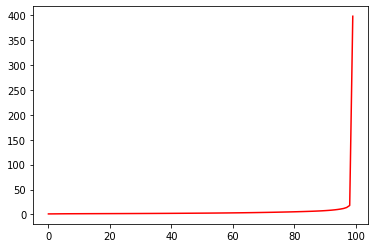

In [27]:
plt.plot(range(len(per100)), per100, c='r')
plt.show()

In [28]:
kf = KF()

tmp = test_data.copy()
th_delta = 0.0001
th = 45 
th_dis = 13
# 5.006
# tmp.loc[((tmp['lngDeg_mean_delta_3'] > th_delta) | (tmp['latDeg_mean_delta_3'] > th_delta) | \
#          (tmp['lngDeg_mean_delta_2'] > th_delta) | (tmp['latDeg_mean_delta_2'] > th_delta) | \
#          (tmp['lngDeg_mean_delta_1'] > th_delta) | (tmp['latDeg_mean_delta_1'] > th_delta) | \
#          (tmp['dist_between_base_and_kf'] > 10) | \
#          (tmp['heightAboveWgs84EllipsoidM'] > 189) | (tmp['heightAboveWgs84EllipsoidM'] < -100) | \
#          (pred['dis_pred'] > th_dis))
#         , ['latDeg', 'lngDeg']] = np.nan 

print(tmp.loc[((pred['dis_pred'] > th_dis))
        , ['latDeg', 'lngDeg']])

tmp.loc[((pred['dis_pred'] > th_dis))
        , ['latDeg', 'lngDeg']] = np.nan


          latDeg      lngDeg
17     37.416647 -122.082035
18     37.416504 -122.082309
61     37.416542 -122.082116
62     37.416674 -122.081948
64     37.416447 -122.082136
...          ...         ...
91298  37.334047 -121.895585
91301  37.333905 -121.895827
91340  37.331923 -121.900563
91342  37.332159 -121.900446
91475  37.334563 -121.899364

[2170 rows x 2 columns]


In [29]:
kf.apply_kf_smoothing(tmp, "")
smoothed_tmp = mean_with_other_phones(tmp)

100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


In [30]:
data_sub = pd.read_csv('../input/google-smartphone-decimeter-challenge' + '/' + 'sample_submission.csv')
df_sub = data_sub[['phone', 'millisSinceGpsEpoch']].merge(
    smoothed_tmp[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['phone', 'millisSinceGpsEpoch'],
    how='inner')

In [31]:
df_sub.to_csv("./submission_keras_ann_{}.csv".format(th_dis), index=False)